In [1]:
from toolz import *

import pandas as pd
import numpy as np
from scipy.special import expit

from linearmodels.panel import PanelOLS
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

style.use("ggplot")

# Diferencias en Diferencias
 
**Datos de panel**: Un panel es una estructura de datos que tiene observaciones repetidas a lo largo del tiempo. El hecho de que observemos la misma unidad en múltiples períodos de tiempo nos permite ver qué sucede antes y después de que se realice un tratamiento. Esto hace que los datos de panel sean una alternativa prometedora para identificar los efectos causales cuando la aleatorización no es posible.
 
Una práctica común en marketing son los Geo-Experimentos: desplegamos una campaña de marketing en alguna región geográfica pero no en otras y las comparamos. En este diseño, los métodos de datos de panel son particularmente interesantes: podemos recopilar datos en una geografía completa (unidad) a lo largo de múltiples períodos de tiempo.

Los datos de panel son cuando tenemos múltiples unidades `i` durante múltiples períodos de tiempo `t`.

### Descripción del problema

El año 2016 la chilena Daniela Baytelman creó su propia aplicación para celulares llamada `easycancha`, la cual gestiona espacios deportivos. A lo largo del tiempo la startup ha rastreado la cantidad de personas que instalaron su aplicación en distintas ciudades. En algún momento de 2022, la empresa de tecnología lanzó una nueva función en su aplicación. 

Ahora lo contratan a usted como consultor para saber cuántos usuarios nuevos (`instalaciones`) trajo esa función a la empresa. El despliegue fue paulatino. Algunas ciudades obtuvieron la función en `2022-03-01`. Otros, en `2022-08-10`. El despliegue completo al resto de las ciudades solo ocurre en 2023. Dado que nuestros datos solo aumentan hasta el `2022-09-10`, este último grupo puede considerarse el grupo de control. En términos de inferencia causal, la implementación de esta función puede verse como el tratamiento y el `número de instalaciones` puede verse como el resultado. Queremos saber el efecto del tratamiento en el resultado, es decir, el efecto de la nueva función en el número de instalaciones.
 
Observe cómo la empresa de tecnología no puede hacer un experimento aquí. No pueden controlar qué persona se entera de que tiene una nueva función. Decimos que tienen un control limitado sobre la asignación del tratamiento. Eso es porque la unidad de análisis es **personas que aún no son sus clientes**. Quieren saber cuántos de ellos pueden convertir en clientes instalando su aplicación. Por supuesto que no pueden aleatorizar nada para esas personas. Entonces, en cambio, cambiaron la unidad de análisis a ciudades.
 
El grupo de ciudades que obtuvieron la función (recibieron tratamiento) en un momento específico se denomina cohorte. En nuestro caso, tenemos tres cohortes: una que recibió tratamiento en `2022-03-01`, otra que recibió tratamiento en `2022-08-10` y una cohorte de control, que solo recibe tratamiento después del final de nuestros datos. Para tener una idea de cómo se ven estos datos, tracemos el promedio de instalaciones diarias agrupadas por cohorte.

In [2]:
df = pd.read_csv('data_tarea3.csv')
df.drop(columns='Unnamed: 0', inplace=True)
df['fecha'] = pd.to_datetime(df['fecha'])
df['cohorte'] = pd.to_datetime(df['cohorte'])

# Pregunta 0
date = pd.date_range("2022-02-01", "2022-09-10", freq="D")
cohorts = pd.to_datetime(["2022-03-01", "2022-08-10", "2023-01-01"]).date
units = range(1, 100+1)

# Pregunta 2.3
df["tau"] = df.y1 - df.y0

df

,fecha,unidad,cohorte,tendencia,dia,tratamiento,y0,y1,instalaciones,tau
0,2022-02-01,1,2022-08-10,0.000000,0,0,25.796263,28.136263,25.796263,2.34
1,2022-02-02,1,2022-08-10,0.014286,1,0,25.701005,28.041005,25.701005,2.34
2,2022-02-03,1,2022-08-10,0.028571,2,0,25.268150,27.608150,25.268150,2.34
3,2022-02-04,1,2022-08-10,0.042857,3,0,24.570393,26.910393,24.570393,2.34
4,2022-02-05,1,2022-08-10,0.057143,4,0,25.182659,27.522659,25.182659,2.34
...,...,...,...,...,...,...,...,...,...,...
22195,2022-09-06,100,2023-01-01,3.100000,217,0,38.995357,41.335357,38.995357,2.34
22196,2022-09-07,100,2023-01-01,3.114286,218,0,38.745005,41.085005,38.745005,2.34
22197,2022-09-08,100,2023-01-01,3.128571,219,0,37.772793,40.112793,37.772793,2.34
22198,2022-09-09,100,2023-01-01,3.142857,220,0,38.360142,40.700142,38.360142,2.34


## Pregunta 0: 

### Pregunta 0.1:

Grafique un **lineplot** con los datos agrupados por `cohorte` y `fecha` mediante los valores promedio de `instalaciones` (*hint: agregar `.reset_index()` al final de la linea de codigo del agrupamiento*). Además grafique lineas punteadas (*vlines*) en el eje x en la fechas de tratamiento.

### Pregunta 0.2:

Explique brevemente su análisis sobre el gráfico. ¿Qué ocurre con el supuesto de tendencias paralelas?

**Respuesta:**

In [3]:
data = df.groupby(["cohorte", "fecha"])["instalaciones"].mean().reset_index()
data

,cohorte,fecha,instalaciones
0,2022-03-01,2022-02-01,28.198149
1,2022-03-01,2022-02-02,28.102891
2,2022-03-01,2022-02-03,27.670035
3,2022-03-01,2022-02-04,26.972279
4,2022-03-01,2022-02-05,27.584545
...,...,...,...
661,2023-01-01,2022-09-06,30.909313
662,2023-01-01,2022-09-07,30.658960
663,2023-01-01,2022-09-08,29.686749
664,2023-01-01,2022-09-09,30.274098


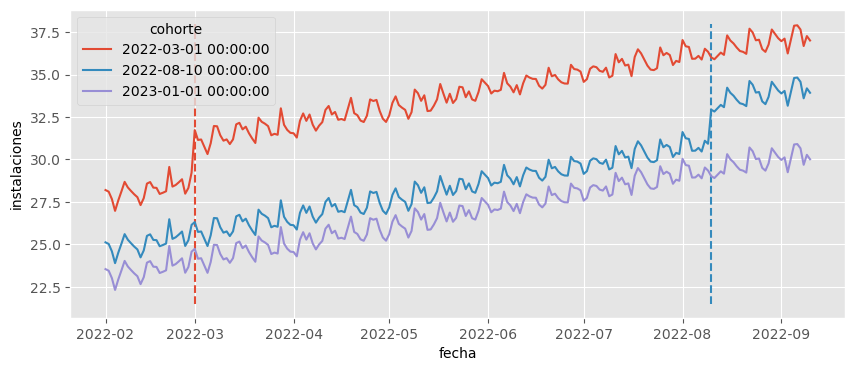

In [4]:
plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=21.5, ymax=38, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts[:-1])]
sns.lineplot(
    data=data,
    x="fecha",
    y = "instalaciones",
    hue="cohorte",
);

## Pregunta 1: 

Formule un modelo (**ecuación**) de regresión lineal con Diff-in-Diff para obtener un modelo de efecto fijo con los datos proporsionados. Donde tengamos $i$ ciudades y $t$ periodos de tiempo.

**Respuesta:**

$$
Instalación_{it} = \tau D_{it} + \gamma_i + \theta_t + e_{it}
$$

donde $\tau$ es el efecto del tratamiento, $D_{it}$ 1 tratado o 0 no tratado, $\gamma_i$ nivel de instalación base, $\theta_t$ nivel de instalación de referencia y $e_{it}$ el error.

## Pregunta 2: 

Estime su modelo anterior con OLS (TWFE)

### Pregunta 2.1:

¿Cuál es el efecto de tratamiento en los tratados (ATT)?

### Pregunta 2.2:

¿Es significativo el efecto (coeficiente $\tau$)?

### Pregunta 2.3:

¿El ATT calculado es igual al de la columna `tau`?

In [5]:
formula = f"""instalaciones ~ tratamiento + C(unidad) + C(fecha)"""

twfe_model = smf.ols(formula, data=df).fit()

twfe_model.params["tratamiento"]

2.3400000000000016

In [6]:
@curry
def demean(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("unidad")[col_to_demean].transform("mean")
                                        - df.groupby("fecha")[col_to_demean].transform("mean"))})


formula = f"""instalaciones ~ tratamiento"""
mod = smf.ols(formula,
              data=df
              .pipe(demean(col_to_demean="tratamiento"))
              .pipe(demean(col_to_demean="instalaciones")))

result = mod.fit()

result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-28.9697,2.74e-15,-1.06e+16,0.000,-28.970,-28.970
tratamiento,2.3400,6.58e-15,3.56e+14,0.000,2.340,2.340


In [7]:
df.query("tratamiento==1")["tau"].mean()

2.34

## Pregunta 3:

Utilizando su modelo TWFE para trazar las predicciones contrafácticas $\hat{Y_0}|t$. Luego utilicelas para complementar su grafico anterior y graficar las predicciones contrafácticas.

### Pregunta 3.1:

Explique brevemente su análisis sobre el gráfico.

In [8]:
df_pred = df.assign(**{"instal_hat": twfe_model.predict(df.assign(**{"tratamiento":0}))})
df_pred

,fecha,unidad,cohorte,tendencia,dia,tratamiento,y0,y1,instalaciones,tau,instal_hat
0,2022-02-01,1,2022-08-10,0.000000,0,0,25.796263,28.136263,25.796263,2.34,25.796263
1,2022-02-02,1,2022-08-10,0.014286,1,0,25.701005,28.041005,25.701005,2.34,25.701005
2,2022-02-03,1,2022-08-10,0.028571,2,0,25.268150,27.608150,25.268150,2.34,25.268150
3,2022-02-04,1,2022-08-10,0.042857,3,0,24.570393,26.910393,24.570393,2.34,24.570393
4,2022-02-05,1,2022-08-10,0.057143,4,0,25.182659,27.522659,25.182659,2.34,25.182659
...,...,...,...,...,...,...,...,...,...,...,...
22195,2022-09-06,100,2023-01-01,3.100000,217,0,38.995357,41.335357,38.995357,2.34,38.995357
22196,2022-09-07,100,2023-01-01,3.114286,218,0,38.745005,41.085005,38.745005,2.34,38.745005
22197,2022-09-08,100,2023-01-01,3.128571,219,0,37.772793,40.112793,37.772793,2.34,37.772793
22198,2022-09-09,100,2023-01-01,3.142857,220,0,38.360142,40.700142,38.360142,2.34,38.360142


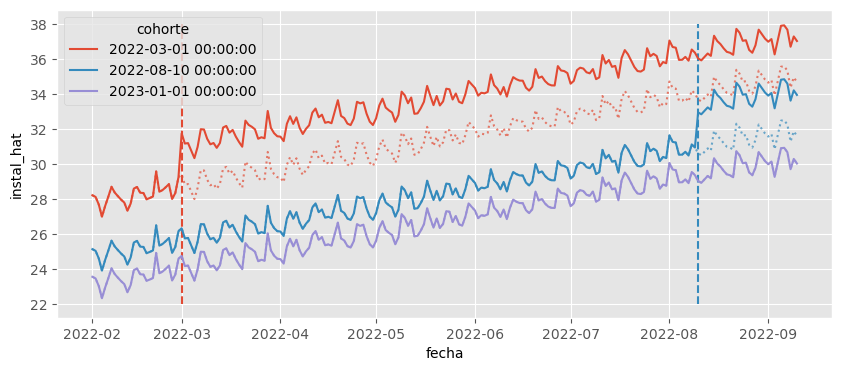

In [9]:
plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=22, ymax=38, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts[:-1])]

sns.lineplot(
    data=(df_pred
          .groupby(["cohorte", "fecha"])["instal_hat"]
          .mean()
          .reset_index()),
    x="fecha",
    y = "instal_hat",
    hue="cohorte",
    alpha=0.7,
    ls="dotted",
    legend=None
)
sns.lineplot(
    data=(df_pred
          .groupby(["cohorte", "fecha"])["instalaciones"]
          .mean()
          .reset_index()),
    x="fecha",
    y = "instalaciones",
    hue="cohorte",
);

## Pregunta 4: 

### Pregunta 4.1: 

Realice un test de placebo para validar la estimación de su efecto.

### Pregunta 4.2:

Elija un periodo de tiempo en el que no haya ocurrido tratamiento, y mida si existe un efecto.

----------------------------------------------------------------------------------------

*hint 1: para ambas preguntas elija su grupo de control y tratamiento por cohorte*

In [10]:
cohorte_1 = pd.DataFrame()
cohorte_1['total_inst_feb'] = data[((data['fecha']>='2022-02-01') & (data['fecha']<='2022-03-01')) & (data['cohorte']=='2022-08-10')]['instalaciones'].reset_index(drop=True)
cohorte_1['total_inst_marzo'] = data[((data['fecha']>='2022-03-01') & (data['fecha']<='2022-04-01')) & (data['cohorte']=='2022-08-10')]['instalaciones'].reset_index(drop=True)
cohorte_1['state'] = 1
cohorte_1

,total_inst_feb,total_inst_marzo,state
0,25.117225,26.310383,1
1,25.021967,25.731020,1
2,24.589111,25.756815,1
3,23.891355,25.322274,1
4,24.503621,24.898757,1
5,25.039718,25.537335,1
6,25.600672,26.551138,1
7,25.273385,26.535437,1
8,25.064322,26.006406,1
9,24.867820,25.687216,1


In [11]:
cohorte_2 = pd.DataFrame()
cohorte_2['total_inst_feb'] = data[((data['fecha']>='2022-02-01') & (data['fecha']<='2022-03-01')) & (data['cohorte']=='2022-08-10')]['instalaciones'].reset_index(drop=True)
cohorte_2['total_inst_marzo'] = data[((data['fecha']>='2022-03-01') & (data['fecha']<='2022-04-01')) & (data['cohorte']=='2022-08-10')]['instalaciones'].reset_index(drop=True)
cohorte_2['state'] = 1
cohorte_2

,total_inst_feb,total_inst_marzo,state
0,25.117225,26.310383,1
1,25.021967,25.731020,1
2,24.589111,25.756815,1
3,23.891355,25.322274,1
4,24.503621,24.898757,1
5,25.039718,25.537335,1
6,25.600672,26.551138,1
7,25.273385,26.535437,1
8,25.064322,26.006406,1
9,24.867820,25.687216,1


In [12]:
cohorte_3 = pd.DataFrame()
cohorte_3['total_inst_feb'] = data[((data['fecha']>='2022-02-01') & (data['fecha']<='2022-03-01')) & (data['cohorte']=='2023-01-01')]['instalaciones'].reset_index(drop=True)
cohorte_3['total_inst_marzo'] = data[((data['fecha']>='2022-03-01') & (data['fecha']<='2022-04-01')) & (data['cohorte']=='2023-01-01')]['instalaciones'].reset_index(drop=True)
cohorte_3['state'] = 0
cohorte_3

,total_inst_feb,total_inst_marzo,state
0,23.539408,24.732566,0
1,23.444150,24.153203,0
2,23.011294,24.178998,0
3,22.313538,23.744457,0
4,22.925804,23.320940,0
5,23.461901,23.959518,0
6,24.022855,24.973321,0
7,23.695568,24.957619,0
8,23.486505,24.428589,0
9,23.290003,24.109399,0


In [13]:
did = pd.concat([cohorte_2,cohorte_3], axis=0)
did

,total_inst_feb,total_inst_marzo,state
0,25.117225,26.310383,1
1,25.021967,25.731020,1
2,24.589111,25.756815,1
3,23.891355,25.322274,1
4,24.503621,24.898757,1
5,25.039718,25.537335,1
6,25.600672,26.551138,1
7,25.273385,26.535437,1
8,25.064322,26.006406,1
9,24.867820,25.687216,1


In [14]:
did.groupby('state').mean()

,total_inst_feb,total_inst_marzo
state,,
0,23.600494,24.578059
1,25.178311,26.155876


In [15]:
print(f"Diferencia antes/después para el grupo de control: {round(did.groupby('state').mean().iloc[0,1], 2)} - {round(did.groupby('state').mean().iloc[0,0],2)} = {round(did.groupby('state').mean().iloc[0,1]-did.groupby('state').mean().iloc[0,0],2)}")
print(f"Diferencia antes/después para el grupo de tratamiento: {round(did.groupby('state').mean().iloc[1,1], 2)} - {round(did.groupby('state').mean().iloc[1,0],2)} = {round(did.groupby('state').mean().iloc[1,1]-did.groupby('state').mean().iloc[1,0],2)}")
print('-------------------------------------------------------')
print(f"DiD: {round(did.groupby('state').mean().iloc[1,1]-did.groupby('state').mean().iloc[1,0],2)} - ({round(did.groupby('state').mean().iloc[0,1]-did.groupby('state').mean().iloc[0,0],2)}) = {round(did.groupby('state').mean().iloc[1,1]-did.groupby('state').mean().iloc[1,0],2)-round(did.groupby('state').mean().iloc[0,1]-did.groupby('state').mean().iloc[0,0],2)}")

Diferencia antes/después para el grupo de control: 24.58 - 23.6 = 0.98
Diferencia antes/después para el grupo de tratamiento: 26.16 - 25.18 = 0.98
-------------------------------------------------------
DiD: 0.98 - (0.98) = 0.0


In [16]:
control_before = did.groupby('state').mean().iloc[0, 0]
control_after = did.groupby('state').mean().iloc[0, 1]
treat_before = did.groupby('state').mean().iloc[1, 0]
treat_after = did.groupby('state').mean().iloc[1, 1]

In [17]:
df_before = did[['total_inst_feb', 'state']]
df_before['T'] = 0
df_before.columns = ['inst', 'W', 'T']

df_after = did[['total_inst_marzo', 'state']]
df_after['T'] = 1
df_after.columns = ['inst', 'W', 'T']

df_reg = pd.concat([df_before, df_after])

df_reg['WT'] = df_reg['W'] * df_reg['T']

df_reg

,inst,W,T,WT
0,25.117225,1,0,0
1,25.021967,1,0,0
2,24.589111,1,0,0
3,23.891355,1,0,0
4,24.503621,1,0,0
...,...,...,...,...
24,24.427485,0,1,0
25,24.513536,0,1,0
26,24.456568,0,1,0
27,26.015017,0,1,0


In [18]:
df_reg[['W', 'T', 'WT']]

,W,T,WT
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
24,0,1,0
25,0,1,0
26,0,1,0
27,0,1,0


In [19]:
lr = LinearRegression()

X = df_reg[['W', 'T', 'WT']]
y = df_reg.inst

lr.fit(X, y)
lr.coef_

array([ 1.57781712e+00,  9.77564355e-01, -6.66133815e-16])

In [20]:
ols = ols('inst ~ W + T + WT', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                   inst   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     99.68
Date:                Wed, 21 Jun 2023   Prob (F-statistic):           1.74e-31
Time:                        14:14:43   Log-Likelihood:                -98.975
No. Observations:                 116   AIC:                             206.0
Df Residuals:                     112   BIC:                             217.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.6005      0.107    219.879      0.0

**Respuesta 4.1**

Podemos ver que si utilizamos el `cohorte 1 (2022-03-01)` como grupo tratado y el `cohorte 3 (2023-01-01)` como grupo de control, el efecto de tratamiento es 0; por lo tanto tenemos validez del experimento.

In [21]:
cohorte_2_time = pd.DataFrame()
cohorte_2_time['total_inst_mayo'] = data[((data['fecha']>='2022-05-01') & (data['fecha']<='2022-06-01')) & (data['cohorte']=='2022-08-10')]['instalaciones'].reset_index(drop=True)
cohorte_2_time['total_inst_junio'] = data[((data['fecha']>='2022-06-01') & (data['fecha']<='2022-07-01')) & (data['cohorte']=='2022-08-10')]['instalaciones'].reset_index(drop=True)
cohorte_2_time['state'] = 1
cohorte_2_time

,total_inst_mayo,total_inst_junio,state
0,27.180178,28.904951,1
1,27.913631,28.468093,1
2,28.297879,28.634732,1
3,27.787668,28.599682,1
4,27.630908,28.683525,1
5,27.502665,29.682462,1
6,26.975727,29.069538,1
7,27.368416,28.871188,1
8,28.697276,28.536514,1
9,28.483560,28.961455,1


In [22]:
cohorte_3_time = pd.DataFrame()
cohorte_3_time['total_inst_mayo'] = data[((data['fecha']>='2022-05-01') & (data['fecha']<='2022-06-01')) & (data['cohorte']=='2023-01-01')]['instalaciones'].reset_index(drop=True)
cohorte_3_time['total_inst_junio'] = data[((data['fecha']>='2022-06-01') & (data['fecha']<='2022-07-01')) & (data['cohorte']=='2023-01-01')]['instalaciones'].reset_index(drop=True)
cohorte_3_time['state'] = 0
cohorte_3_time

,total_inst_mayo,total_inst_junio,state
0,25.602361,27.327134,0
1,26.335814,26.890276,0
2,26.720062,27.056915,0
3,26.209851,27.021865,0
4,26.053091,27.105708,0
5,25.924848,28.104645,0
6,25.397910,27.491721,0
7,25.790599,27.293371,0
8,27.119458,26.958697,0
9,26.905743,27.383637,0


In [23]:
did = pd.concat([cohorte_2_time,cohorte_3_time], axis=0)
did

,total_inst_mayo,total_inst_junio,state
0,27.180178,28.904951,1
1,27.913631,28.468093,1
2,28.297879,28.634732,1
3,27.787668,28.599682,1
4,27.630908,28.683525,1
...,...,...,...
27,26.458086,28.329422,0
28,26.975428,28.296082,0
29,27.730207,28.181498,0
30,27.524422,27.573721,0


In [24]:
did.groupby('state').mean()

,total_inst_mayo,total_inst_junio
state,,
0,26.592787,27.600959
1,28.170604,29.178776


In [25]:
print(f"Diferencia antes/después para el grupo de control: {round(did.groupby('state').mean().iloc[0,1], 2)} - {round(did.groupby('state').mean().iloc[0,0],2)} = {round(did.groupby('state').mean().iloc[0,1]-did.groupby('state').mean().iloc[0,0],2)}")
print(f"Diferencia antes/después para el grupo de tratamiento: {round(did.groupby('state').mean().iloc[1,1], 2)} - {round(did.groupby('state').mean().iloc[1,0],2)} = {round(did.groupby('state').mean().iloc[1,1]-did.groupby('state').mean().iloc[1,0],2)}")
print('-------------------------------------------------------')
print(f"DiD: {round(did.groupby('state').mean().iloc[1,1]-did.groupby('state').mean().iloc[1,0],2)} - ({round(did.groupby('state').mean().iloc[0,1]-did.groupby('state').mean().iloc[0,0],2)}) = {round(did.groupby('state').mean().iloc[1,1]-did.groupby('state').mean().iloc[1,0],2)-round(did.groupby('state').mean().iloc[0,1]-did.groupby('state').mean().iloc[0,0],2)}")

Diferencia antes/después para el grupo de control: 27.6 - 26.59 = 1.01
Diferencia antes/después para el grupo de tratamiento: 29.18 - 28.17 = 1.01
-------------------------------------------------------
DiD: 1.01 - (1.01) = 0.0


In [26]:
control_before = did.groupby('state').mean().iloc[0, 0]
control_after = did.groupby('state').mean().iloc[0, 1]
treat_before = did.groupby('state').mean().iloc[1, 0]
treat_after = did.groupby('state').mean().iloc[1, 1]

In [27]:
df_before = did[['total_inst_mayo', 'state']]
df_before['T'] = 0
df_before.columns = ['inst', 'W', 'T']

df_after = did[['total_inst_junio', 'state']]
df_after['T'] = 1
df_after.columns = ['inst', 'W', 'T']

df_reg = pd.concat([df_before, df_after])

df_reg['WT'] = df_reg['W'] * df_reg['T']

df_reg

,inst,W,T,WT
0,27.180178,1,0,0
1,27.913631,1,0,0
2,28.297879,1,0,0
3,27.787668,1,0,0
4,27.630908,1,0,0
...,...,...,...,...
27,28.329422,0,1,0
28,28.296082,0,1,0
29,28.181498,0,1,0
30,27.573721,0,1,0


In [28]:
lr = LinearRegression()

X = df_reg.dropna()[['W', 'T', 'WT']]
y = df_reg.dropna().inst

lr.fit(X, y)
lr.coef_

array([1.57781712e+00, 1.00817150e+00, 2.22044605e-16])

**Respuesta 4.2**

Podemos ver que si utilizamos el `cohorte 2 (2022-08-10)` como grupo tratado y el `cohorte 3 (2023-01-01)` como grupo de control, el efecto de tratamiento es 0; por lo tanto tenemos validez del experimento.